# Now let's add an imaging simulation example##

- this notebook is available as a [colab notebook](https://colab.research.google.com/drive/1AMKoOjs7y6l18d70RcbHMLU9ZFxkzRpO?usp=sharing)

Now that we've seen how a nonlinear 1D signal can be made linear by using Vandermonde interpolation, we can quickly expand our discussion to images by treating each pixel as a 1D function of intensity to be corrected.

Let's first see how a nonlinearity introduced in our project data is reflected in the reconstructed image...

We start with a simplified model of beam hardening described in: https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.2742501

where the polychromatic attenuation coefficient $\langle \mu \rangle$ can be modeled in terms of the true attenuation coefficient $\mu$ and penetration distance $x$

\begin{equation}
\langle \mu \rangle = \frac{\mu_0}{1+\lambda x}
\end{equation}

Note: $\lambda$ is a fitting parameter (*not* wavelength) that controls the strength of beam hardening. If $\lambda = 0$ then there is no beam hardening. If $\lambda= \infty $ then $\langle \mu \rangle = 0$

Limitation: Because we cannot easily separate $x$ and $\mu$ we know that in the ideal case $-ln(I/I_0) = \int \mu dx$ thus here we need to make the assumption that materials have about equal $\mu$ (i.e.) that $\mu$ doesn't contribute to beam hardening (which we know not to be true because bone will harden more than water). But we'll make this assumption just for this demonstration.

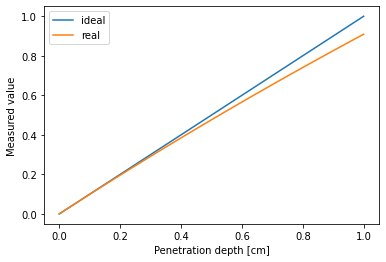

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x = np.linspace(0, 1)
lam = 0.1 #set small amount of beam hardening
mu = x
def beamHardening(x, lam=1): #here we cannot separate mu and penetration distance so we have to assume them to be equal
  return x/(1+lam*x)

plt.plot(x, mu, label='ideal')
plt.plot(x, beamHardening(x, lam), label = 'real')
plt.xlabel('Penetration depth [cm]')
plt.ylabel('Measured value')
plt.legend()
plt.show()

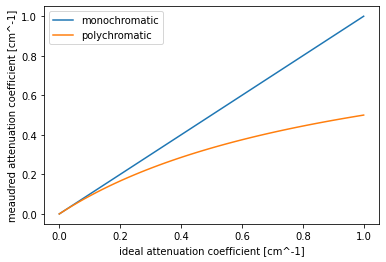

In [2]:
plt.plot(mu, mu, label='monochromatic')
plt.plot(mu, beamHardening(mu), label ='polychromatic')
plt.xlabel('ideal attenuation coefficient [cm^-1]')
plt.ylabel('meaudred attenuation coefficient [cm^-1]')
plt.legend()
plt.show()

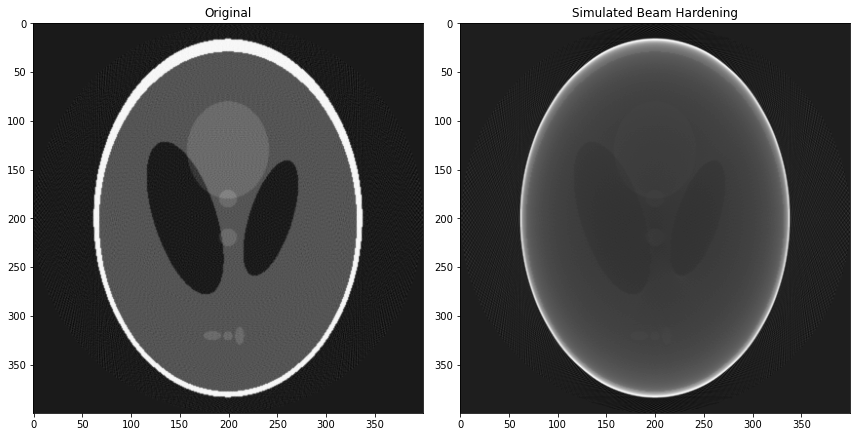

In [3]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon

p = shepp_logan_phantom()
p = rescale(p, scale=1, mode='reflect', multichannel=False)
theta = np.linspace(0., 360., 360, endpoint=False)
r = radon(p, theta=theta)
ideal = iradon(r, theta=theta)
corrupted_r = beamHardening(r, lam=0.1) #here we cannot separate mu and penetration distance so we have to assume them to be equal
uncorrected = iradon(corrupted_r, theta=theta)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 

ax1.set_title("Original")
ax1.imshow(ideal, cmap=plt.cm.Greys_r)

ax2.set_title("Simulated Beam Hardening")
ax2.imshow(uncorrected, cmap=plt.cm.Greys_r)
          
fig.tight_layout()
plt.show()

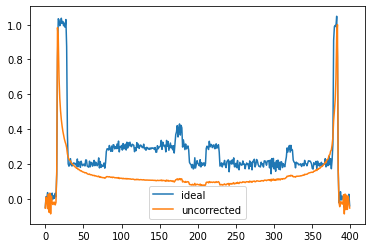

In [4]:
idealLine=ideal[:,int(ideal.shape[0]/2)]
uncorrectedLine=uncorrected[:,int(ideal.shape[0]/2)]
uncorrectedLine/=max(uncorrectedLine) #normalized for easier comparison
plt.plot(idealLine)
plt.plot(uncorrectedLine)
plt.legend(["ideal","uncorrected"])
plt.show()

## Comparison to Kak and Slaney ch. 4 method
Used by Chabior 2011

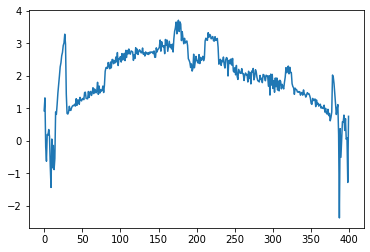

In [5]:
correctionLineFunc = idealLine/uncorrectedLine
plt.plot(correctionLineFunc)

This is clearly

Let's assume a 0th order correction, a polynomial with degree 1, $N=1$ $p = \sum_{n} cq^{n} = c_0 + c_1 q$, but we assume $c_0 = 0$ so $p=cq$

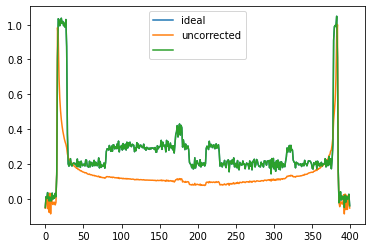

In [6]:
plt.plot(idealLine)
plt.plot(uncorrectedLine)
plt.plot(uncorrectedLine*correctionLineFunc)
plt.legend(["ideal","uncorrected",""])
plt.show()

In [7]:
print(correctionLineFunc.shape)
print(corrupted_r.shape)
pc = np.zeros([corrupted_r.shape[0], corrupted_r.shape[1]])
for i in np.arange(1,corrupted_r.shape[1]):
  pc[:,i] = corrupted_r[:,i]*correctionLineFunc

(400,)
(400, 360)


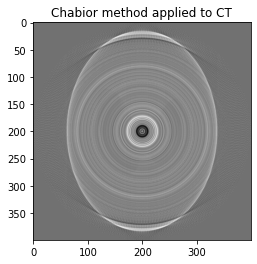

In [8]:
chabior_corrected = iradon(pc, theta=theta)

plt.imshow(chabior_corrected, cmap = 'gray')
plt.title("Chabior method applied to CT")
plt.show()

In our first imaging example we will start by fitting one polynomial fit function to applied to uniformly to every pixel in our 400x400 pixel image. 

We can generate our new Vandermonde matrix, let's start with $n=3$ monomial terms, since each image has $400^2=160000$ pixels our matrix will look like

\begin{bmatrix}
1       & x_0   & x_0^2      \\ 
1       & x_1   & x_1^2      \\
\vdots  &\vdots &\vdots      \\
1       & x_m   &x_{15999}^2 \\
\end{bmatrix}

In [0]:
def poly_recon(A, theta):
  """Argument is projection vandermonde matrix [proj.ravel() X view angles] and theta array, returns recon.ravel() X deg matrix of vandermonde recons"""
  deg=A.shape[1]
  sz = int(A.shape[0]/theta.size)
  A=A.reshape([sz,theta.size,deg])
  f = np.zeros([sz*sz,deg])
  for i in range(deg):
      fi=iradon(A[:,:,i],theta=theta, circle=True)
      f[:,i]=fi.ravel()
  return f
  
def vanderRecon(proj, theta, deg):
  """Argument is [xpix*ypix X theta] projection, returns [recon.ravel() X deg] matrix of vandermonde reconstructed projections"""
  A=np.vander(corrupted_r.ravel(),deg, increasing=True)
  return poly_recon(A,theta);

Let's confirm that the size of the Vandermonde matrix of our recons is what we expect...

In [10]:
deg=3 #set number of monomial terms
A = vanderRecon(corrupted_r, theta, deg)
print(A.shape)

(160000, 3)


In [11]:
A_rank = np.linalg.matrix_rank(A)
print(A_rank)

3


Now let's define our correction function once we determine our coefficients and a loss function to define our mean squared error MSE

In [0]:
def mse(y_hat,y):
   return ((y_hat-y)**2).mean()

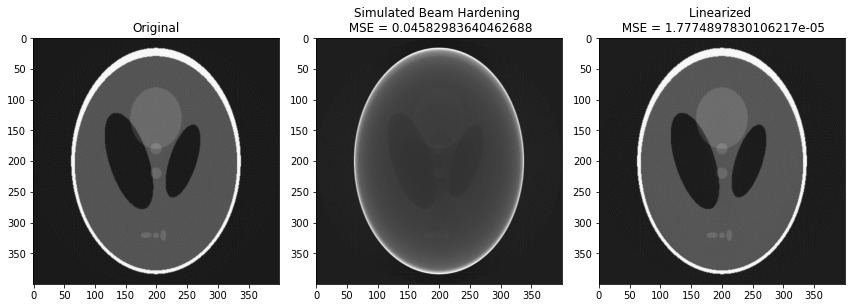

In [13]:
deg=8 #set number of monomial terms
A = vanderRecon(corrupted_r, theta, deg)
c = np.linalg.lstsq(A,ideal.ravel(),rcond=None)[0]
corrected_proj=np.polynomial.polynomial.polyval(corrupted_r, c).reshape(corrupted_r.shape)

uncorrected = iradon(corrupted_r, theta=theta, circle=True)
corrected   = iradon(corrected_proj, theta=theta, circle=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ax1.set_title("Original")
ax1.imshow(ideal, cmap=plt.cm.Greys_r)

ax2.set_title("Simulated Beam Hardening \n MSE = " + str(mse(uncorrected,ideal)))
ax2.imshow(uncorrected, cmap=plt.cm.Greys_r)

ax3.set_title("Linearized \n MSE = " + str(mse(corrected,ideal)))
ax3.imshow(corrected, cmap=plt.cm.Greys_r)
          
fig.tight_layout()
plt.show()

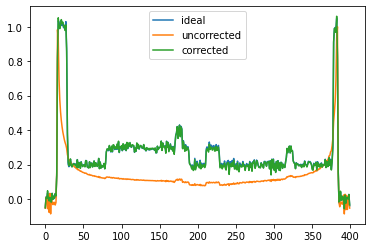

In [14]:
correctedLine=corrected[:,int(ideal.shape[0]/2)]
plt.plot(idealLine)
plt.plot(uncorrectedLine)
plt.plot(correctedLine)
plt.legend(["ideal","uncorrected","corrected"])
plt.show()

#Now let's add a spatially varying component#

In [0]:
import random
def add_lines(r):
    n_lines = int(random.random()*40)
    for i in range(n_lines):
      line_intensity = random.uniform(0.5,1)
      line_width = int(10*random.random())
      line_location = int(random.random()*r.shape[0])
      r[line_location:line_location+line_width,:]*=line_intensity
    return r

In [0]:
def corruptProjection(proj, bh_strength = 0.01, spatialDependence_strength = 1):
  m = np.ones(proj.shape)*(1-spatialDependence_strength) + add_lines(np.ones(proj.shape))*spatialDependence_strength
  corrupted_r = beamHardening(proj*m, lam = bh_strength)
  return m, corrupted_r 

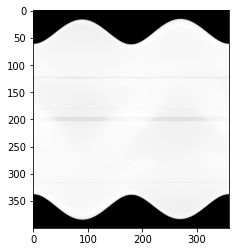

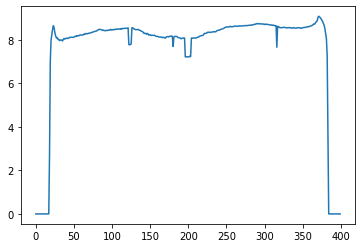

In [17]:
m, corrupted_r=corruptProjection(r, bh_strength=0.1)
plt.imshow(corrupted_r,cmap=plt.cm.Greys_r)
plt.show()
plt.plot(corrupted_r[:,100])
plt.show()

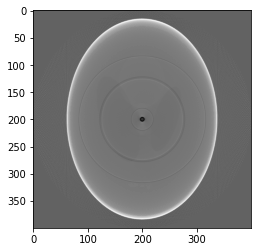

In [18]:
uncorrected = iradon(corrupted_r, theta=theta, circle=True)
plt.imshow(uncorrected,cmap=plt.cm.Greys_r)
plt.show()

## Numpy has a built in 2D vandermonde matrix that we can use here
https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.polynomial.polynomial.polyvander2d.html


In [0]:
def vanderComborecon(q,m,theta,deg):
  qm = np.polynomial.polynomial.polyvander2d(q.ravel(), m.ravel(), [deg-1, deg-1])
  return poly_recon(qm,theta)

In [0]:
deg = 6
f = vanderComborecon(corrupted_r,m,theta, deg)
print("The Vandermonde matrix has a shape of [{0:d}, {1:d}] and a condition number of: {2:.0f}".format(f.shape[0], f.shape[1], np.linalg.cond(f)))

The Vandermonde matrix has a shape of [160000, 36] and a condition number of: 3367960979906


Note that the condition number of the $qm$ matrix is very large, meaning that it is pretty poorly conditioned, thus our algorithm will be very sensitive to different input values. Is there a way to decrease the condition number and better condition our problem?

Condition number is a measure of the sensitivty of a problem to error in input. A large condition number number indicates an unstable result that could vary drastically depending on minor errors in the input.

A large condition number is a known problem of vandermonde matrix inversions.

https://en.wikipedia.org/wiki/Condition_number

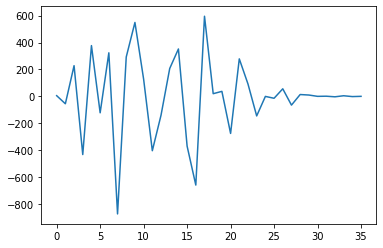

In [0]:
c=np.linalg.lstsq(f,ideal.ravel(),rcond=None)[0]
plt.plot(c)
plt.show() 

Looking at our coefficients above and how large and widely varying they are is a result of the problem being poorly conditioned, not only do these coefficients vary widely with small changes in input (try re-running the program again with noise added), but also the coefficients aren't very intuitive at all.

In [0]:
def square(c):
  return c.reshape([int(np.sqrt(len(c))), -1])

def performCorrection2D(corrupted_r, m, c):
  return np.polynomial.polynomial.polyval2d(corrupted_r.ravel(), m.ravel(), square(c)).reshape(corrupted_r.shape)

## Let's visualize the coefficients to see what basis images contribute the most

Recall the correction is $\hat{p} = c_{i,j} q^i M^j$ thus the coordinates in the image below indicate the monomial and its relative contribution to the polynomial

0.00014014461661890804

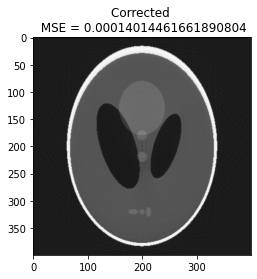

In [0]:
def correctAndDisplay(corrupted_r, m, c, theta):
  p = performCorrection2D(corrupted_r, m, c)
  corrected = iradon(p, theta=theta, circle=True)
  plt.imshow(corrected, cmap=plt.cm.Greys_r)
  ms_error = mse(corrected,ideal)
  plt.title("Corrected \n MSE = " + str(ms_error))
  return ms_error

correctAndDisplay(corrupted_r, m, c, theta)

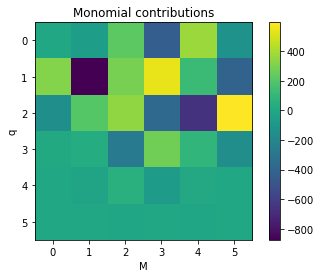

In [0]:
def visualizeCoefficients(c):
  plt.imshow(square(c))
  plt.xlabel('M')
  plt.ylabel('q')
  plt.colorbar()
  plt.title('Monomial contributions')

visualizeCoefficients(c)

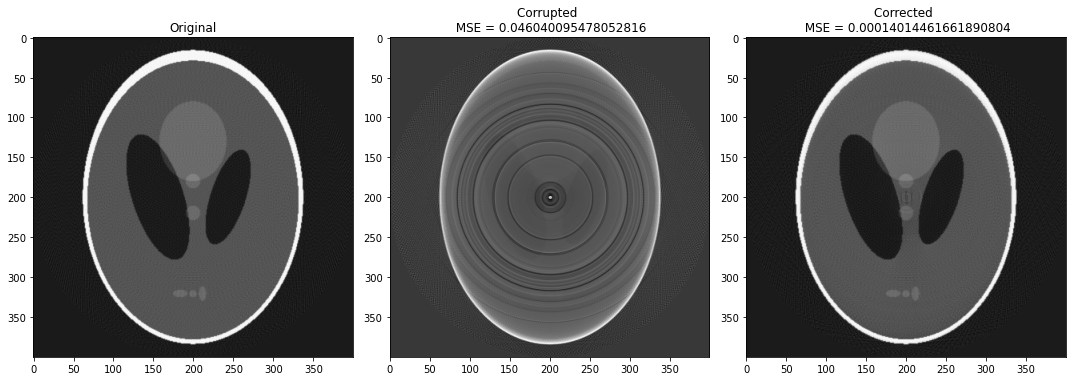

In [0]:
p = performCorrection2D(corrupted_r, m, c)
corrected = iradon(p, theta=theta, circle=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 12))

ax1.set_title("Original")
ax1.imshow(ideal, cmap=plt.cm.Greys_r)

ax2.set_title("Corrupted \n MSE = " + str(mse(uncorrected,ideal)))
ax2.imshow(uncorrected, cmap=plt.cm.Greys_r)

ax3.set_title("Corrected \n MSE = " + str(mse(corrected,ideal)))
ax3.imshow(corrected, cmap=plt.cm.Greys_r)
          
fig.tight_layout()
plt.show()

Not bad results for 10% beam hardening! 

## Finally, is there a pattern that emerges in the monomials that are activated?



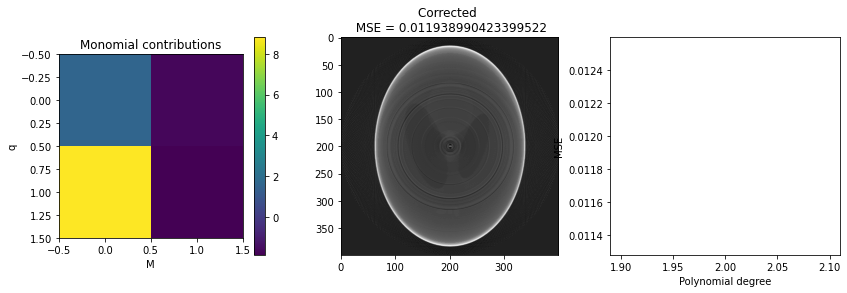

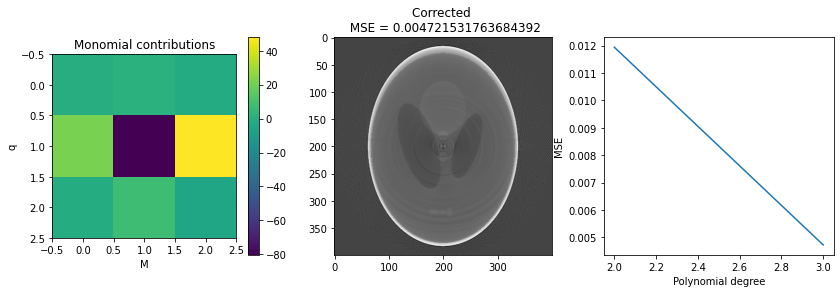

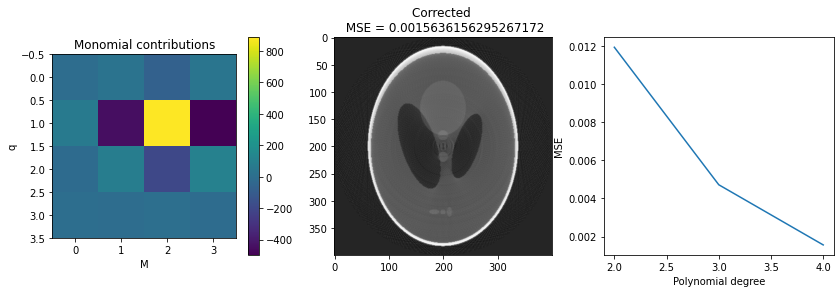

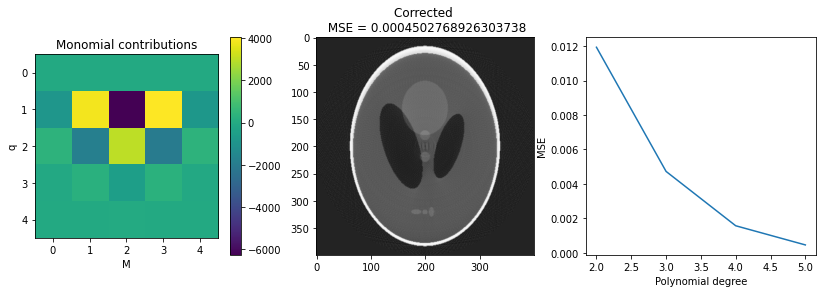

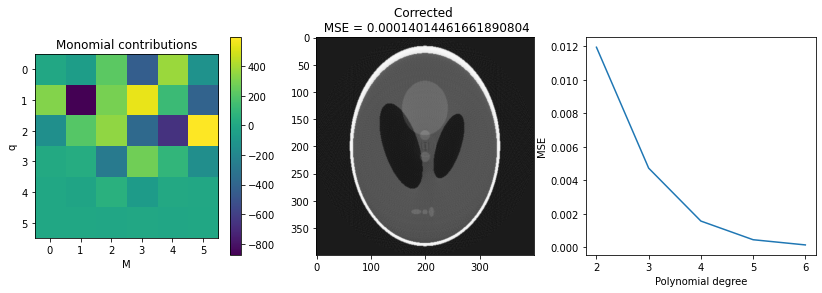

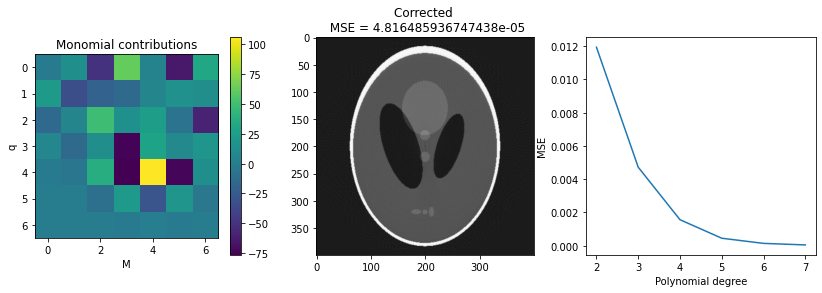

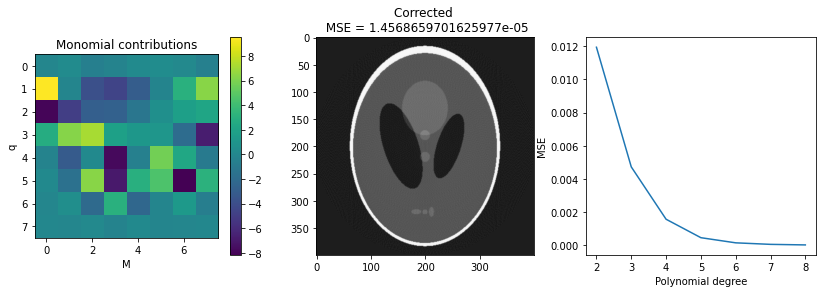

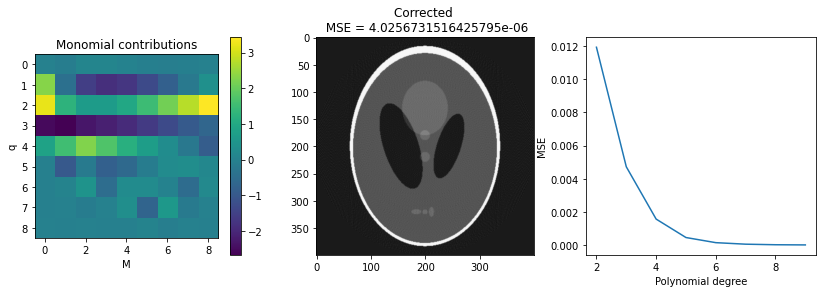

In [0]:
def find2Dpolynomialcoefficients(corrupted_r, m, theta, deg):
  f = vanderComborecon(corrupted_r,m,theta, deg)
  return np.linalg.lstsq(f,ideal.ravel(),rcond=None)[0]

def plotAndVisualizeDegreeDependence(corrupted_r, m, theta, maxDegree=10):
  ms_error = []
  for d in np.arange(2, maxDegree):
    coefficients = find2Dpolynomialcoefficients(corrupted_r, m, theta, d)

    plt.figure(figsize=[14,4])
    plt.subplot(1,3,1)
    visualizeCoefficients(coefficients)
    plt.subplot(1,3,2)
    err = correctAndDisplay(corrupted_r, m, coefficients, theta)
    ms_error.append(err)
    plt.subplot(1,3,3)
    plt.plot(np.arange(2, d+1), ms_error)
    plt.xlabel('Polynomial degree')
    plt.ylabel('MSE')
    plt.show()

plotAndVisualizeDegreeDependence(corrupted_r, m, theta)

It's clear that MSE decreases and asymptotes as the polynomial degrees increase (but at the cost of 

## How do spatial dependence strength vs beam hardening strength control monomial activation map?
Try this again when there is no spatial component to the beam hardening, how does this affect the M dependency?

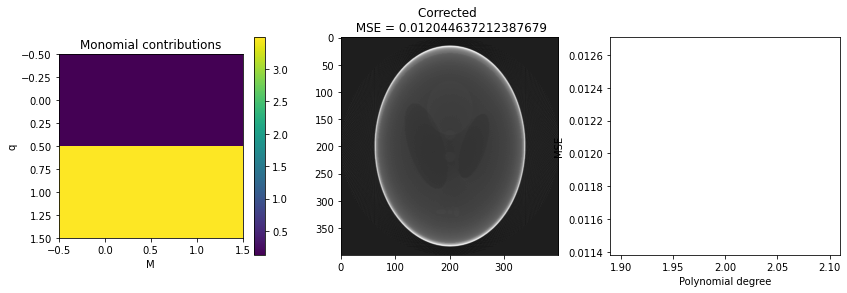

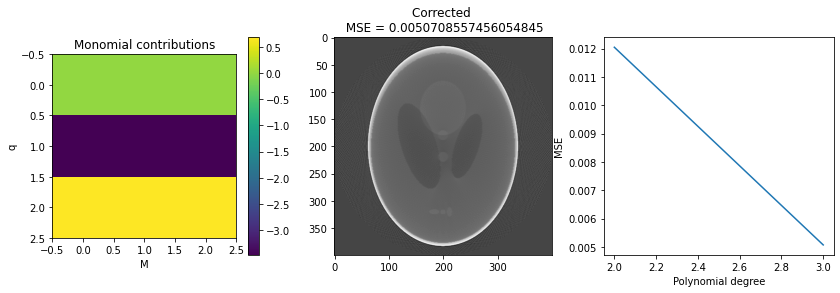

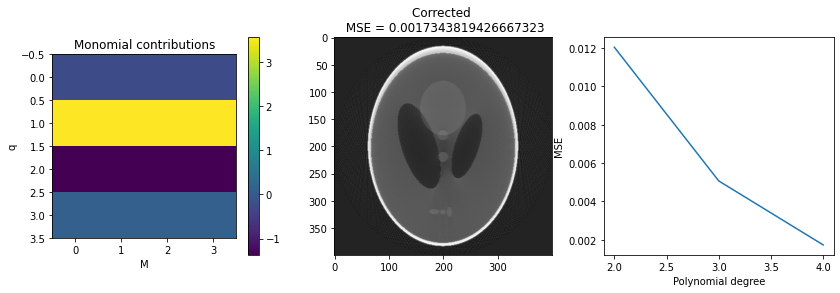

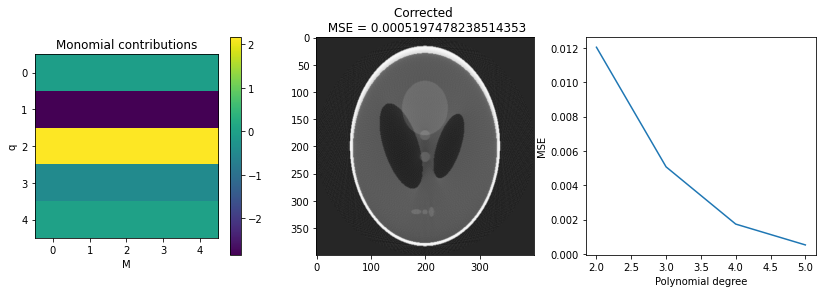

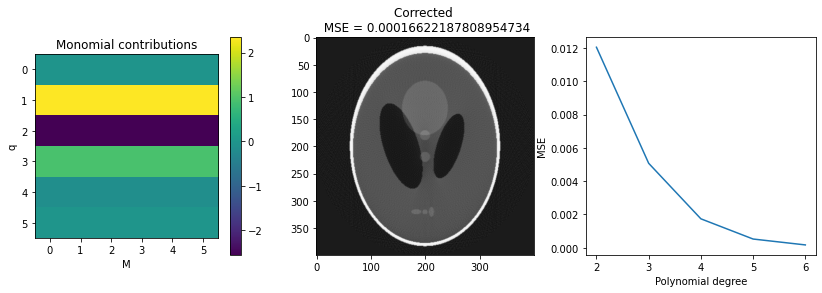

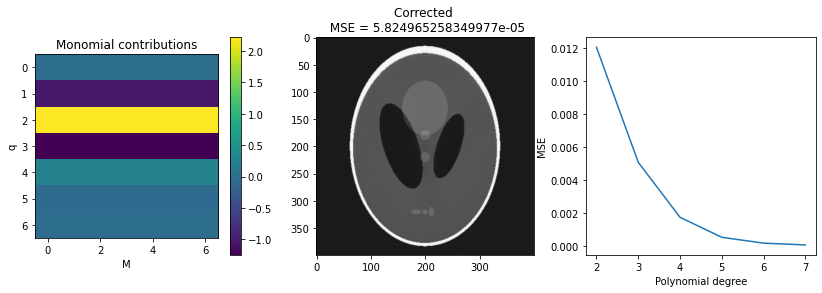

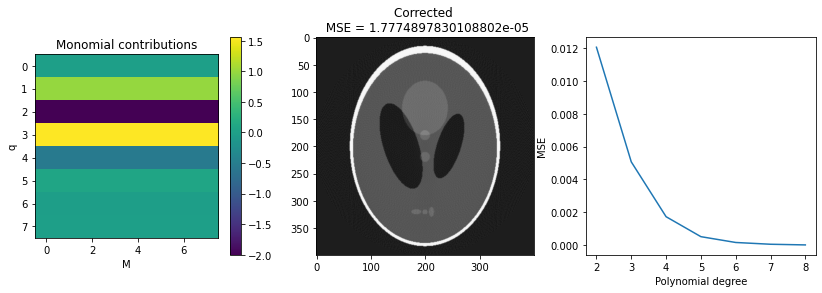

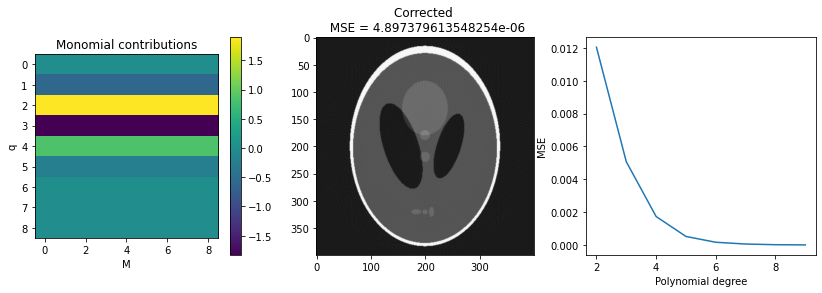

In [0]:
noSpatialm, noSpatial_corrupted_r = corruptProjection(r, bh_strength=0.1, spatialDependence_strength = 0)
plotAndVisualizeDegreeDependence(noSpatial_corrupted_r, noSpatialm, theta)

Finally repeat once more with Beam hardening strength set to zero and spatiall varying strength on max, how does this affect the coefficient activation map?

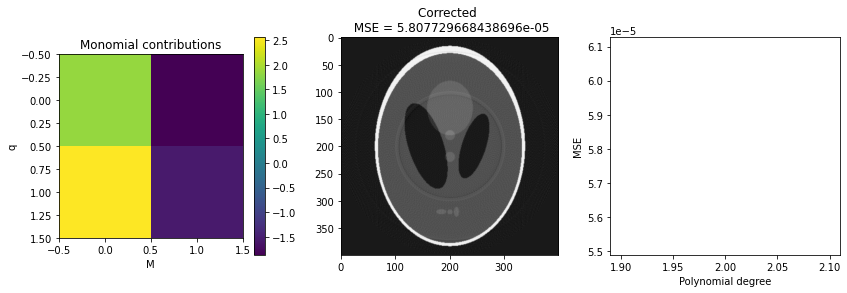

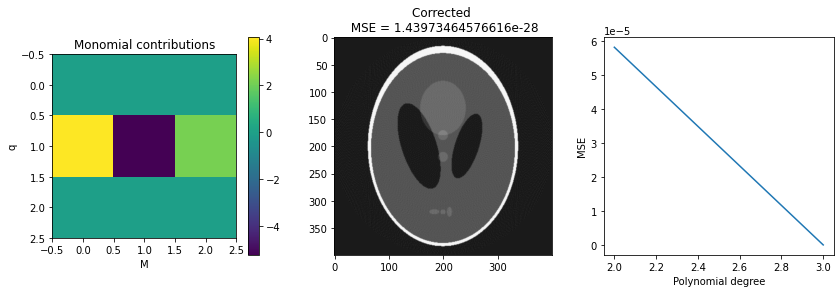

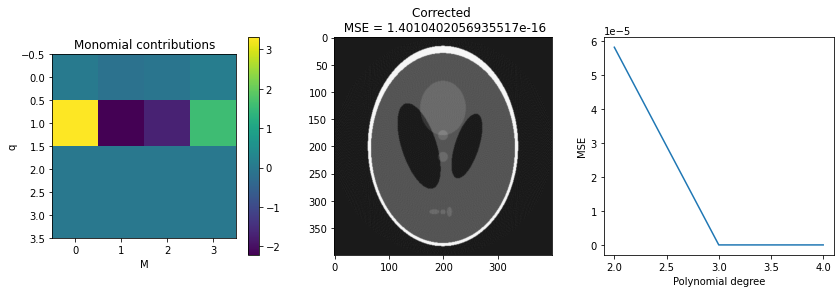

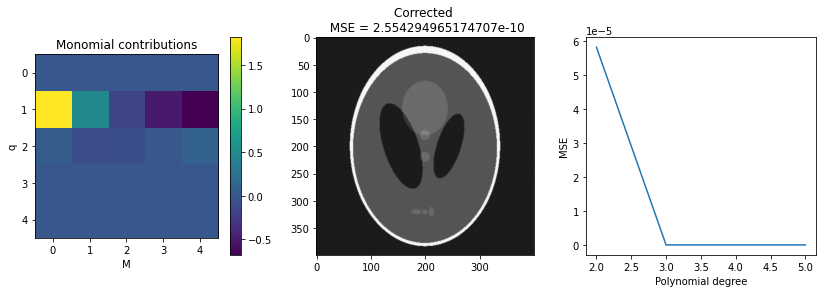

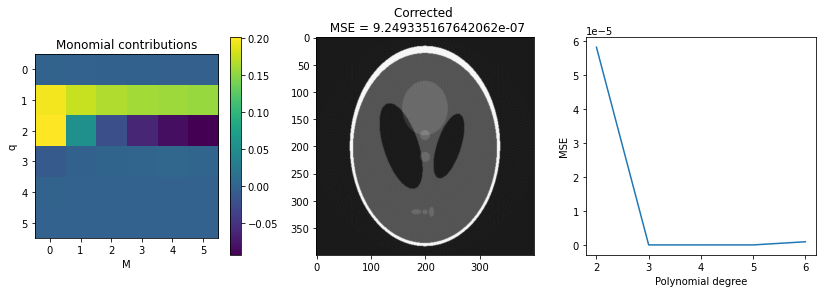

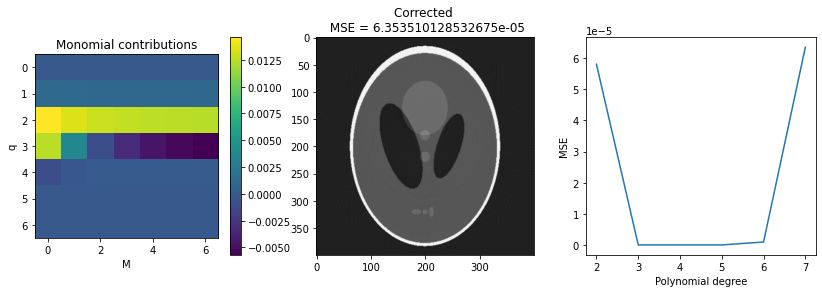

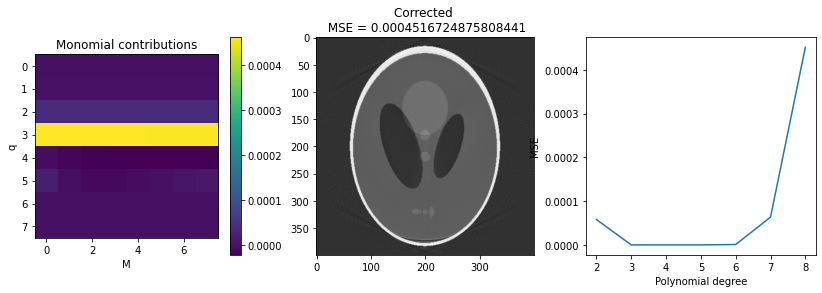

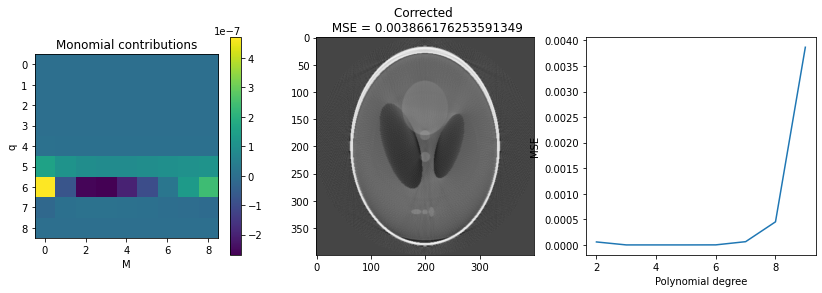

In [0]:
noBHm, noBH_corrupted_r = corruptProjection(r, bh_strength=0, spatialDependence_strength = 1)
plotAndVisualizeDegreeDependence(noBH_corrupted_r, noBHm, theta)

Observe how the MSE decreases then increases at higher degrees. This demonstrates a weakness of Vandermonde polynomial interpolation that as the Vandermonde matrix becomes larger its condition number grows dramatically and the result becomes unstable.

Move on to the last notebook on iterative methods for solving the Vandermonde interpolation least squares problem: https://colab.research.google.com/drive/1kErNKAbJlJUpq2jsb0roMJA7kTNB9vY0
